# Data Preparation

## Examples
Below is are examples of the images we will be testing this model on. The dataset OpenGlue's authors reference in their readme is one containing images of buildings from different positions. Each "scene" contains images of the same building taken from different positions and with different conditions.

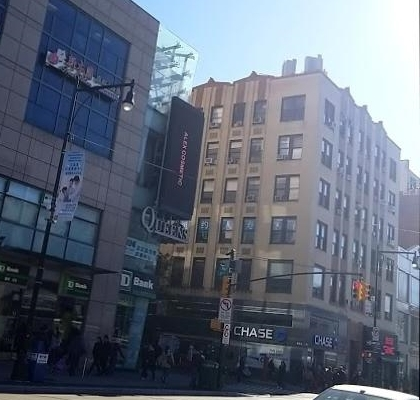

In [1]:
from IPython.display import Image
Image(filename='imgs/test_images/img2.jpg')  

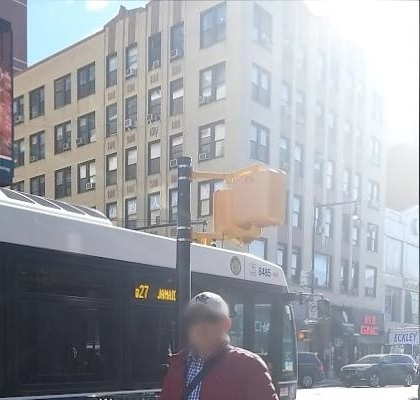

In [2]:
Image(filename='imgs/test_images/img3.jpg')

### Training data
#### Steps to prepare MegaDepth dataset for training
1) Create folder `MegaDepth`, where your dataset will be stored.
   ```
   mkdir MegaDepth && cd MegaDepth
   ```
2) Download and unzip `MegaDepth_v1.tar.gz` from official [link](https://www.cs.cornell.edu/projects/megadepth/dataset/Megadepth_v1/MegaDepth_v1.tar.gz).
You should now be able to see `MegaDepth/phoenix` directory.
3) We provide the lists of pairs for training and validation, [link](https://drive.google.com/file/d/1DQl6N1bKEdzlRteCVMS1bWffz0SU-L9x/view?usp=sharing) to download. Each line corresponds to one pair and has the following structure:
```
path_image_A path_image_B exif_rotationA exif_rotationB [KA_0 ... KA_8] [KB_0 ... KB_8] [T_AB_0 ... T_AB_15] overlap_AB
```
`overlap_AB` - is a value of overlap between two images of the same scene, it shows how close (in position transformation) two images are. 

The resulting directory structure should be as follows:
```
MegaDepth/
   - pairs/
   |   - 0000/
   |   |   - sparse-txt/
   |   |   |    pairs.txt
      ...
   - phoenix/S6/zl548/MegaDepth_v1/
   |   -0000/
   |   |   - dense0/
   |   |   |   - depths/
   |   |   |   |   id.h5
                 ...
   |   |   |   - images/
   |   |   |   |   id.jpg
                 ...
   |   |   - dense1/
            ...
      ...
```

The directory structure needs to be the same as shown, even if the data being used is different. To train on different data, create the same directory structure and with data files in the same format. The folder marked 0000/ above represents that everything inside is a part of the same "scene". In the case of the included dataset, images of the same building from different angles/lightings/etc are considered part of the same scene. The format for pairs.txt is shown above, and is needed to add the additional info about pairs of images that OpenGlue uses in it's training. OpenGlue does not include code to generate these files.

## Take a Subset of the Data
OpenGlue includes files specifying which scenes (as in the folder names which each contain a single scene) are to be used for training, testing, and validation, but does not include code for generating new versions of these or for making a smaller sample set. <br />
To take a subset of the data and only use a small amount in training and testing, we need to generate new versions of these files. The following takes a percentage of the scenes and stores the scene names in files that we can utilize throughout the rest of the pipeline. It also allows you to split the overall subset into a train and validation set via specifying the percentage that should be validation.<br/>
Additionally, store test data in a seperate folder. OpenGlue tests via running inference on 2 jpg images. The images to test on are not provided by OpenGlue, but you can use kaggle data to test (https://www.kaggle.com/competitions/image-matching-challenge-2022/data?select=test_images) or use other images that are applicable.

In [3]:
#Generate files for train/validate split
import torch
import torch.utils.data as data
import os
import random
def split_data(root_data_dir, percent_used, validate_set_percent, split_config_dir, split_config_name):
    all_scenes = os.listdir(root_data_dir)
    sub_set = [scene for scene in all_scenes if random.random() <= percent_used]
    
    train_set_size = int(len(sub_set) * (1-validate_set_percent))
    valid_set_size = len(sub_set) - train_set_size
    
    seed = torch.Generator().manual_seed(42)
    train_set, valid_set = data.random_split(sub_set, [train_set_size, valid_set_size], generator=seed)
     
    sub_set_path = os.path.join(split_config_dir, split_config_name+'-total.txt')
    train_set_path = os.path.join(split_config_dir, split_config_name+'-train.txt')
    val_set_path = os.path.join(split_config_dir, split_config_name+'-val.txt')
    
    with open(sub_set_path, 'w') as fout:
        for scene in sub_set:
            fout.write(scene+'\n')
    with open(train_set_path, 'w') as fout:
        for scene in train_set:
            fout.write(scene+'\n')
    with open(val_set_path, 'w') as fout:
        for scene in valid_set:
            fout.write(scene+'\n')
    return train_set_path, val_set_path, sub_set_path, sub_set, [scene for scene in train_set], [scene for scene in valid_set]

/root/code/OpenGlue/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#Make sure you enter the filepath to your data folder here. This is the location inside of the unzipped files from the first steps where the scene folders are stored
data_folder = '/host_Data/Data/MegaDepth/MegaDepth/phoenix/S6/zl548/MegaDepth_v1'

#This is the percent of the overall dataset you wish to use in the subset in decimal form
percent_used = 0.025

#This is the percent of the subset you wish to use as the validation set in decimal form. The remaining amount will be the train set
val_percent = 0.2

#This is the location where the files generated that specify which scenes to use are saved.
#You will need to update the config files in the training/feature extraction steps based on where you save these.
split_files_dir = './assets/'

#This is the name of this specific split of the data. The files specifying the train set, validate set, and the overall 
#subset will begin with this name and end with -train.txt, -val.txt, and -total.txt respectively
name = 'subset-0025-02'

train_set_path, val_set_path, sub_set_path, sub_set, train_set, val_set = split_data(data_folder, percent_used, val_percent, split_files_dir, name)

#### Train/Validation Data
Below you can generate random examples of the images being used to train/validate the model

##### Samples from Train Set

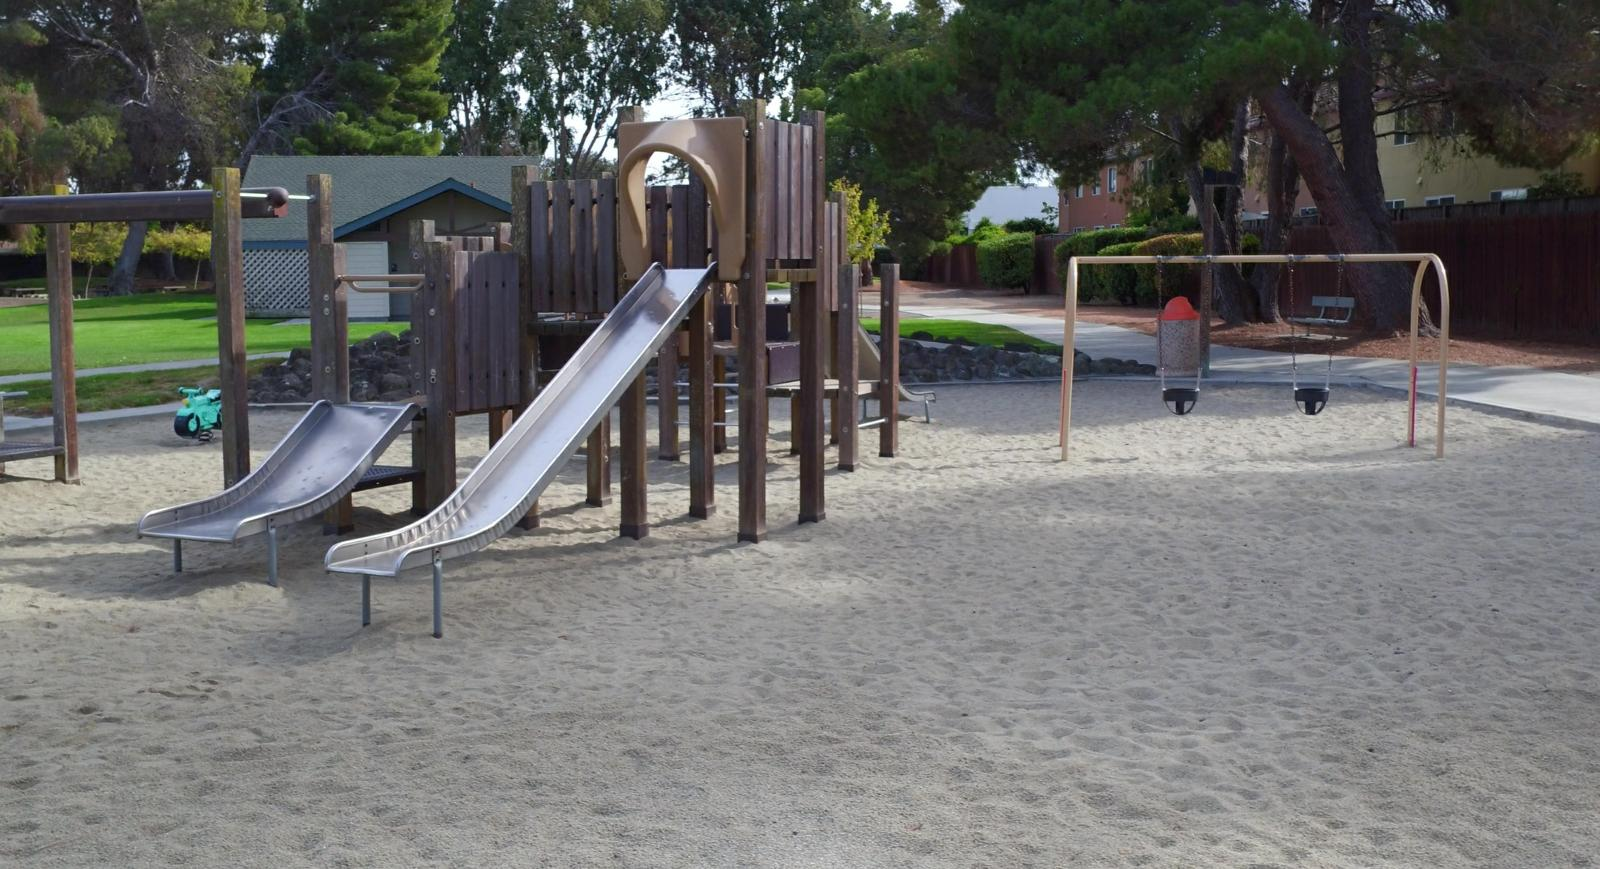

In [5]:
import os
import random
scene = os.path.join(data_folder, random.choice(train_set), 'dense0/imgs/')
Image(filename=os.path.join(scene, random.choice(os.listdir(scene))))

##### Samples from Validate Set

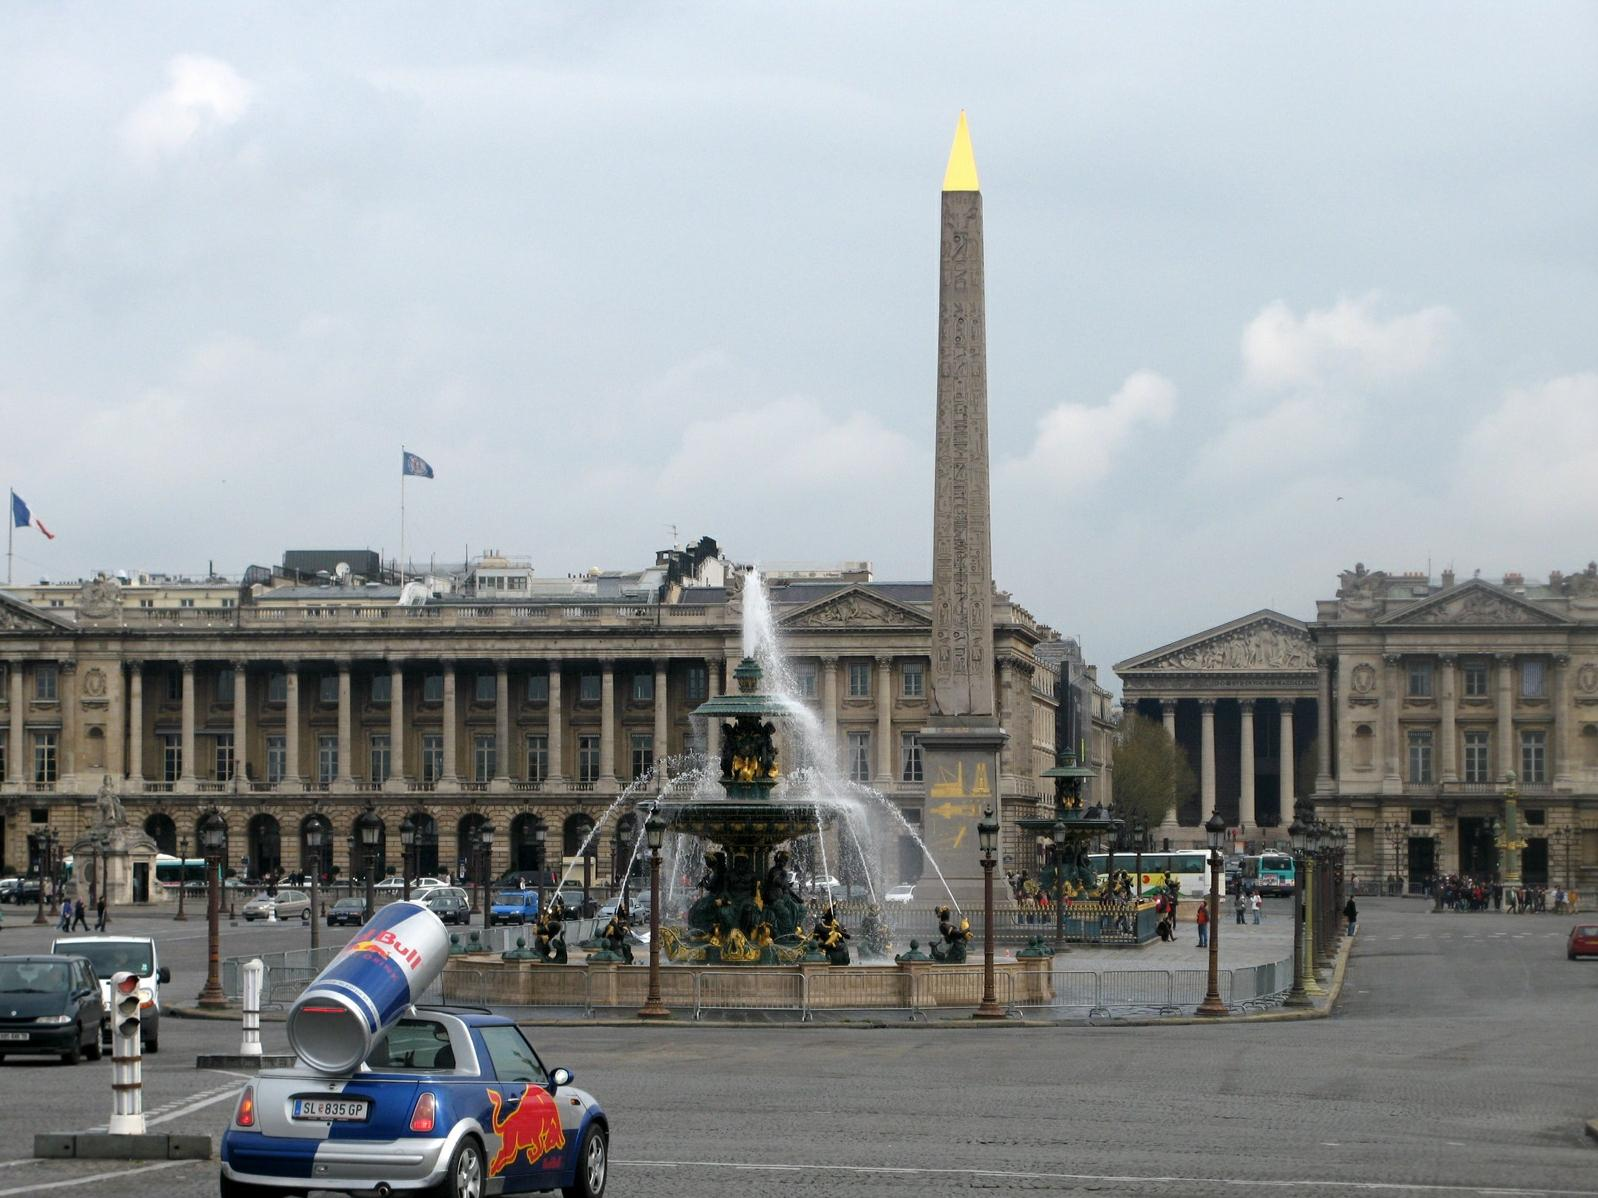

In [6]:
import os
import random
scene = os.path.join(data_folder, random.choice(val_set), 'dense0/imgs/')
Image(filename=os.path.join(scene, random.choice(os.listdir(scene))))